## *Legend of the Five Rings* 4th edition

In this system you roll a number of exploding d10s (i.e. if you roll a 10, you roll it again and add it to the running total, as long as you keep rolling 10s). Then you keep a number of the highest among them and sum.

This is an infamous challenge for dice calculators.

### AnyDice

AnyDice uses an external server and appears to take exponential time in the number of dice. For example, [this script](https://anydice.com/program/27be7)

```
set "explode depth" to 4
output [highest 3 of 5d[explode d10]]
```

takes between 2 and 3 seconds. Increasing the number of dice rolled from 5 to 6 causes the computation to exceed AnyDice's 5-second timeout.

### Troll

The [conference paper](http://hjemmesider.diku.dk/~torbenm/Troll/Troll-SAC.pdf) for the [Troll dice roller and probability calculator](https://topps.diku.dk/torbenm/troll.msp) says:

> For example, the game "Legend of Five Rings" uses a roll mechanism that can be described in Troll as
>
> ``` sum (largest M N#(sum accumulate x := d10 until x<10)) ```
>
> where M and N depend on the situation. With M = 3, N = 5 and the maximum number of iterations for accumulate set to 5, Troll takes nearly 500 seconds to calculate the result, and it gets much worse if any of the numbers increase.

(Note that Troll counts the base d10 as an iteration while AnyDice does not, so the actual number of iterations is the same as the AnyDice example above.)

To be fair, this paper was presented more than a decade ago, and hardware has advanced considerably since then. After compling Troll and running it on my Intel i5-8400, the same computation now takes about 100 seconds. If we increase the nubmer of dice rolled $N$ to 6, the computation fails to complete in 2000 seconds. So a roughly five-fold advancement in hardware cannot overcome even modest increases in the parameters.

### SnakeEyes

A Lua-language calculator that runs locally in the browser. [Here *L5R* again takes a long time.](https://snake-eyes.io/?script=DYVgTgBAvBAmCMAGAXAUwB4AdgHtaoAokAaCAFgEoAoK7HAFwIJAgCoJQwLlYwdMA+rgDuqAM6MATBQpA). The author did come up with an [optimized script](https://snake-eyes.io/?url=examples/l5r.lua) for *L5R* in particular, though this still takes some time especially as the explosion depth increases.

### lynks.se

There does exist a website with *L5R* probabilities: [lynks.se](https://lynks.se/probability/). However, if you look at that webpage's source code, you'll see that the probabilities have been precomputed and stored in static arrays. Furthermore, there is a small but noticeable amount of noise in the data, suggesting that it was computed via Monte Carlo rather than a closed-form method.

### hdroller

Now let's give `hdroller` a try. First, import it:

In [1]:
import piplite
await piplite.install("hdroller")

import hdroller
import time

Notes:

* Internal computations will be cached, so subsequent runs will run faster. Restart the kernel for a more "fair" comparison.
* JupyterLite runs the computation right in your own browser, not an external server.

Computation time: 38 ms


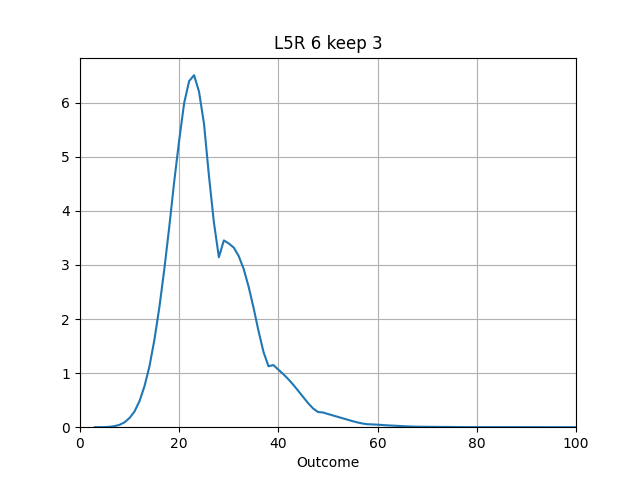

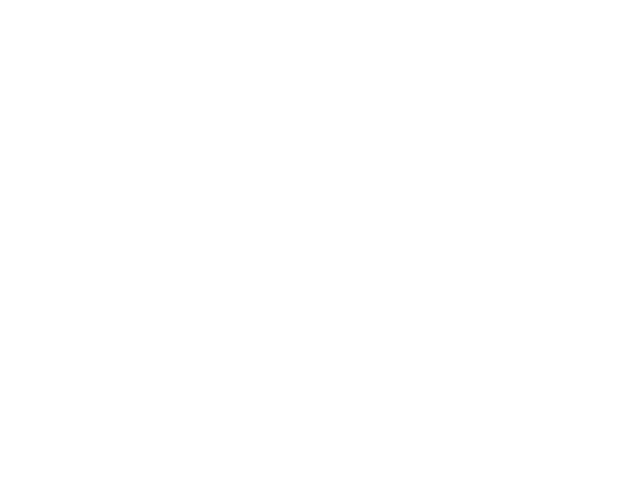

In [2]:
start_ns = time.perf_counter_ns()
result = hdroller.d10.explode(max_depth=4).keep_highest(6, 3)
end_ns = time.perf_counter_ns()
elapsed_ms = round((end_ns - start_ns) * 1e-6)
print(f'Computation time: {elapsed_ms} ms')

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(result.outcomes(), result.pmf(percent=True))
ax.set_title('L5R 6 keep 3')
ax.set_xlabel('Outcome')
ax.set_xlim(0, 100)
ax.set_ylim(0)
ax.grid(True)
plt.show()

Indeed, this continues to scale well with increases to any of the parameters. Here's roll 10 keep 5 with a maximum explosion depth of 9:

Computation time: 273 ms


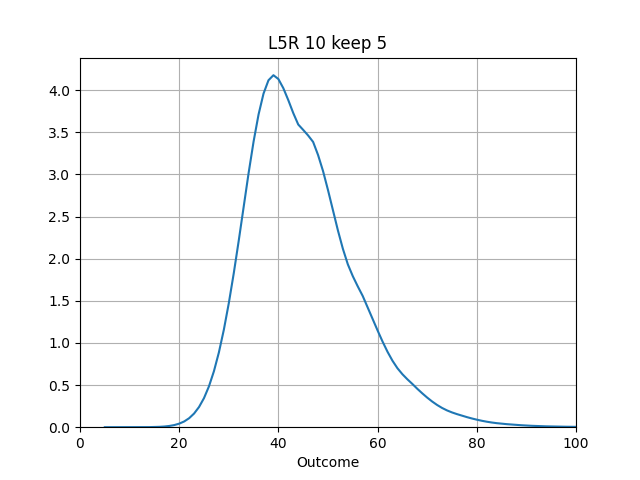

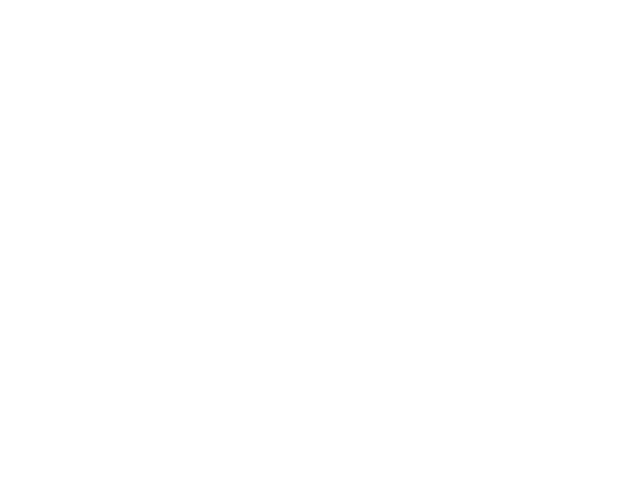

In [3]:
start_ns = time.perf_counter_ns()
result = hdroller.d10.explode(max_depth=9).keep_highest(10, 5)
end_ns = time.perf_counter_ns()
elapsed_ms = round((end_ns - start_ns) * 1e-6)
print(f'Computation time: {elapsed_ms} ms')

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(result.outcomes(), result.pmf(percent=True))
ax.set_title('L5R 10 keep 5')
ax.set_xlabel('Outcome')
ax.set_xlim(0, 100)
ax.set_ylim(0)
ax.grid(True)
plt.show()

## Emphasis

Emphasis is simple, just add a reroll after the explode. (Putting it before the explode would cause 1s on every explosion to be rerolled once.)

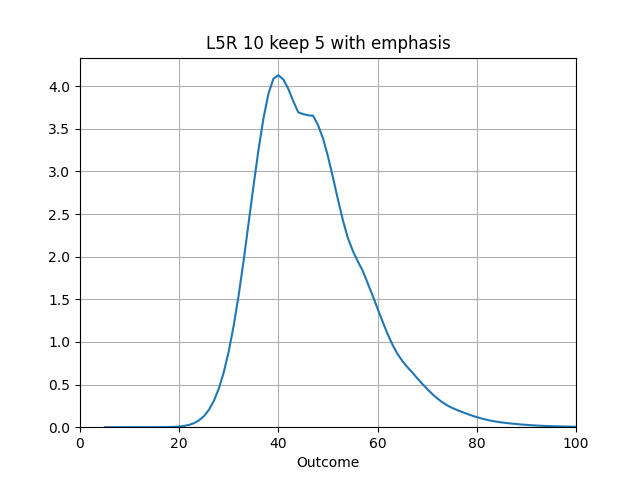

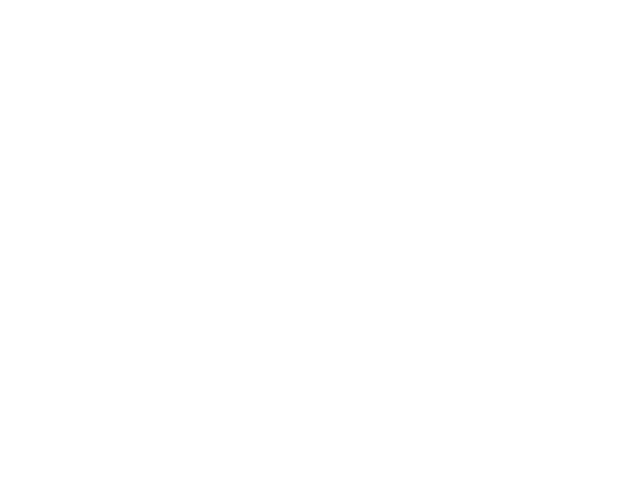

In [4]:
# reroll() rerolls the min outcome by default.
result_emphasis = hdroller.d10.explode(max_depth=9).reroll(max_depth=1).keep_highest(10, 5)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(result_emphasis.outcomes(), result_emphasis.pmf(percent=True))
ax.set_title('L5R 10 keep 5 with emphasis')
ax.set_xlabel('Outcome')
ax.set_xlim(0, 100)
ax.set_ylim(0)
ax.grid(True)
plt.show()

## Interactive version

TODO: Find a faster replot method. At time of writing, ipympl seems to get stuck on "Loading widget..."

In [5]:
from ipywidgets import interact
import ipywidgets as widgets

@interact(roll=widgets.IntSlider(value=6, min=1, max=10), 
          keep=widgets.IntSlider(value=3, min=1, max=10), 
          explode=widgets.IntSlider(value=10, min=9, max=11),
          emphasis=False)
def l5r(roll, keep, explode, emphasis):
    result = hdroller.d10.explode(lambda x: x >= explode, max_depth=9)
    if emphasis:
        result = result.reroll(max_depth=1)
    result = result.keep_highest(roll, keep)
    fig, ax = plt.subplots()
    plt.plot(result.outcomes(), result.pmf(percent=True))
    ax.grid(True)
    ax.set_xlim(0, 100)
    ax.set_ylim(bottom=0)
    ax.set_ylabel('Chance (%)')
    plt.show()
    plt.close()

interactive(children=(IntSlider(value=6, description='roll', max=10, min=1), IntSlider(value=3, description='k…